# Math1 dataset preprocessing
### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../../../')
sys.path.append('../')
from experiments.datasets.data_utils.preprocessing_utilities import stat_unique, get_modalities_nb, remove_duplicates, densify,create_q2k, encode_attr, quadruplet_format, parse_data, split_data, save_to_csv,get_metadata, split_data_vertically,rescaling_dict,one_hot_encoding,split_small_data_vertically

import json
import pandas as pd
import numpy as np

### Load and merge dataset

In [5]:
raw_data = pd.read_csv('../1-raw_data/math_1.csv', encoding="ISO-8859-15", low_memory=False)


raw_data = raw_data.drop(columns=['Unnamed: 0.2',  'Unnamed: 0',
       'Unnamed: 0.1', 'start_time', 'Unnamed: 0.1.1', 'qr',
       'qr_compl', 'split'])

raw_data =  raw_data.rename(columns={"skill_id": "dimension_id"})
raw_data.head()

,dimension_id,user_id,item_id,correct
0,"{0, 1, 10, 9}",0,0,1.0
1,"{2, 7}",0,1,1.0
2,"{2, 10}",0,2,1.0
3,"{9, 10, 4}",0,3,1.0
4,"{5, 7}",0,4,1.0


### Split rows with several dimensions

In [6]:
raw_data['dimension_id'] = raw_data['dimension_id'].apply(lambda x: set(map(int, x.strip('{}').split(', '))))
df_expanded = raw_data.explode('dimension_id').reset_index(drop=True)
df_expanded.head()

,dimension_id,user_id,item_id,correct
0,0,0,0,1.0
1,1,0,0,1.0
2,10,0,0,1.0
3,9,0,0,1.0
4,2,0,1,1.0


### Early stats

In [7]:
print(len(df_expanded))
all_data = df_expanded.dropna(subset=['user_id','item_id','correct','dimension_id'])
print(len(all_data))

282003
282003


In [8]:
stat_unique(all_data, None)
stat_unique(all_data, ['user_id', 'item_id'])
stat_unique(all_data, 'user_id')
stat_unique(all_data, 'item_id')
stat_unique(all_data, 'dimension_id')

Total length: 282003
Number of unique [user_id,item_id]: 84180
Number of unique user_id: 4209
Number of unique item_id: 20
Number of unique dimension_id: 11


### Clean Nan values

In [9]:
cleaned_data = all_data.dropna(subset=['user_id','item_id','dimension_id','correct'], axis='index')

### Remove duplicated user and id rows

In [10]:
unduplicated_data = remove_duplicates(cleaned_data,key_attrs=['user_id','item_id','dimension_id'],agg_attrs=[])

### Filter Data

In [11]:
filtered_data_0 = unduplicated_data
filtered_q_nb = 1
filtered_u_nb = 0
filtered_d_nb = 0
while filtered_q_nb!=0 or filtered_u_nb!=0 or filtered_d_nb!=0 : 
    # filter items
    filtered_data_1, filtered_q_nb = densify(filtered_data_0,'item_id','user_id',5)
    # filter users
    filtered_data_2, filtered_u_nb = densify(filtered_data_1,'user_id','item_id',5)
    # filter knowledges
    filtered_data_3, filtered_d_nb = densify(filtered_data_2,'dimension_id','item_id',3)
    filtered_data_0 = filtered_data_3
    
stat_unique(filtered_data_0, None)
stat_unique(filtered_data_0, ['user_id', 'item_id'])
stat_unique(filtered_data_0, 'user_id')
stat_unique(filtered_data_0, 'item_id')
stat_unique(filtered_data_0, 'dimension_id')

filter 0 item_id
filter 0 user_id
filter 3 dimension_id
filter 0 item_id
filter 0 user_id
filter 0 dimension_id
Total length: 265167
Number of unique [user_id,item_id]: 84180
Number of unique user_id: 4209
Number of unique item_id: 20
Number of unique dimension_id: 8


### Encoding

In [12]:
# renumber the users
u_enc_data, u2n = encode_attr(filtered_data_0, "user_id")

In [13]:
# renumber the items
q_enc_data, q2n = encode_attr(u_enc_data, "item_id")

In [14]:
# renumber the dimensions
d_enc_data, d2n = encode_attr(q_enc_data, "dimension_id")

### Maps creation

In [15]:
q2k, k2q = create_q2k(d_enc_data)

### Rescaling responses

In [16]:
resc_data = d_enc_data
resc_data['correct'] = resc_data['correct'].astype(float)
min_val = resc_data['correct'].min()
max_val = resc_data['correct'].max()
resc_data['correct'] = (resc_data['correct']-min_val)/(max_val-min_val) +1
print(f'min value : {resc_data["correct"].min()}, max value : {resc_data["correct"].max()}')

min value : 1.0, max value : 2.0


### Get final stats and create metadata

In [17]:
stat_unique(resc_data, None)
stat_unique(resc_data, ['user_id', 'item_id'])
stat_unique(resc_data, 'user_id')
stat_unique(resc_data, 'item_id')
stat_unique(resc_data, 'dimension_id')
stat_unique(resc_data, 'correct')

resc_data_dim_grouped_items = resc_data.groupby("dimension_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("dimension_id")["user_id"].nunique()
print('#questions/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("item_id")["dimension_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("item_id")["user_id"].nunique()
print('#categorys/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("user_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("user_id")["dimension_id"].nunique()
print('#questions/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#categorys/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

Total length: 265167
Number of unique [user_id,item_id]: 84180
Number of unique user_id: 4209
Number of unique item_id: 20
Number of unique dimension_id: 8
Number of unique correct: 19
#questions/category: 3 & 8 &  17
#users/category: 4209 & 4209 &  4209
#categorys/question: 1 & 3 &  7
#users/question: 4209 & 4209 &  4209
#questions/users: 20 & 20 &  20
#categorys/users: 8 & 8 &  8


Text(0.5, 1.0, 'Distribution of Responses')

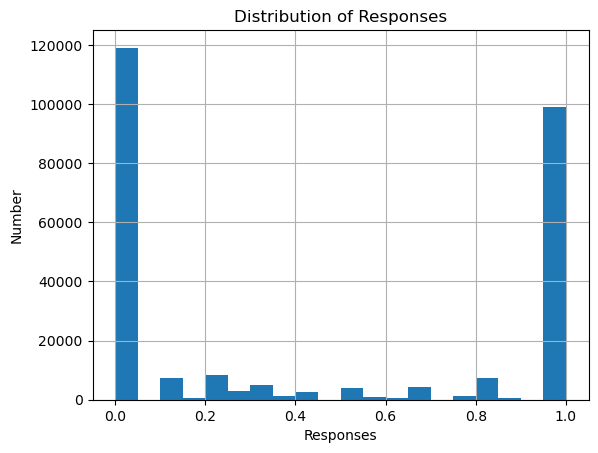

In [18]:
import matplotlib.pyplot as plt

# draw a histogram of the age column
(resc_data['correct']-1).hist(bins=20)

# add labels and title
plt.xlabel('Responses')
plt.ylabel('Number')
plt.title('Distribution of Responses')


In [19]:
plt.savefig('distribution_math1.png')

<Figure size 640x480 with 0 Axes>

In [20]:
metadata = get_metadata(resc_data,["user_id", "item_id", "dimension_id"])

## Compute nb of modalities

In [21]:
nb_modalities = get_modalities_nb(resc_data, metadata)

### Save data, concept map, metadata and nb of modalities

In [36]:
# save selected data
resc_data.to_csv('../1-raw_data/math1_selected_data.csv', index=False)

In [37]:
# Convert int64 keys to str
q2k_str_keys = {str(key): value for key, value in q2k.items()}

# Convert sets to lists in the dictionary
q2k_json_serializable = {}
for key, value in q2k_str_keys.items():
    if isinstance(value, set):
        q2k_json_serializable[key] = list(value)
    else:
        q2k_json_serializable[key] = value

# Save concept map
with open('concept_map.json', 'w') as f:
    json.dump(q2k_json_serializable, f)

In [38]:
# save metadata
with open('metadata.json', 'w') as f:
    json.dump(metadata, f)

In [23]:
# save nb_modalities
import torch
torch.save(nb_modalities,'nb_modalities.pkl')

## parse data

In [39]:
resc_data = pd.read_csv('../1-raw_data/math1_selected_data.csv')
quadruplet = quadruplet_format(resc_data)

In [40]:
stu_data, ques_data = parse_data(resc_data)

In [41]:
test_size = 0.2
valid_size = 0.2 # proportion over the all dataset
least_test_length=100

## Horizontal split

In [35]:
train_data, valid_data, test_data = split_data(quadruplet, stu_data, test_prop=test_size, valid_prop=valid_size, least_test_length=least_test_length) 

In [36]:
print(f'train records length: {len(train_data)}')
print(f'test records length: {len(test_data)}')
print(f'valid records length: {len(valid_data)}')
print(f'all records length: {len(train_data)+len(valid_data)+len(test_data)}')

## save row data

In [37]:
save_to_csv(train_data, '../2-preprocessed_data/math1_train_quadruples.csv')
save_to_csv(valid_data, '../2-preprocessed_data/math1_valid_quadruples.csv')
save_to_csv(test_data, '../2-preprocessed_data/math1_test_quadruples.csv')

## vertical split

In [42]:
train_data, valid_data, test_data = split_data_vertically(quadruplet, test_prop=test_size,valid_prop=valid_size,folds_nb=5)

In [43]:
for i_fold, train_fold in enumerate(train_data):
    save_to_csv(train_data[i_fold], f'../2-preprocessed_data/math1_train_quadruples_vert_{i_fold}.csv')
    save_to_csv(valid_data[i_fold], f'../2-preprocessed_data/math1_valid_quadruples_vert_{i_fold}.csv')
    save_to_csv(test_data[i_fold], f'../2-preprocessed_data/math1_test_quadruples_vert_{i_fold}.csv')

#### Toy dataset generation

In [44]:
train_data_small, valid_data_small, test_data_small = split_small_data_vertically(quadruplet, test_prop=0.95,
                                                                                  valid_prop=0.025)

save_to_csv(train_data_small, f'../2-preprocessed_data/math1_small_train_quadruples_vert_{0}.csv')
save_to_csv(valid_data_small, f'../2-preprocessed_data/math1_small_valid_quadruples_vert_{0}.csv')
save_to_csv(test_data_small, f'../2-preprocessed_data/math1_small_test_quadruples_vert_{0}.csv')

In [35]:
len(train_data_small)

45422

### one hot encoding

In [ ]:
train = pd.read_csv("../2-preprocessed_data/math1_train_quadruples.csv").astype({'student_id':int, 'item_id':int, "correct":float})
duplicated_train = one_hot_encoding(train,response_range_dict)
duplicated_train.to_csv('../2-preprocessed_data/math1_train_quadruples_ohe.csv', index=False)

In [ ]:
valid = pd.read_csv("../2-preprocessed_data/math1_valid_quadruples.csv").astype({'student_id':int, 'item_id':int, "correct":float})
duplicated_valid = one_hot_encoding(valid,response_range_dict)
duplicated_valid.to_csv('../2-preprocessed_data/math1_valid_quadruples_ohe.csv', index=False)

In [52]:
test = pd.read_csv("../2-preprocessed_data/math1_test_quadruples.csv")
duplicated_test = one_hot_encoding(test,response_range_dict)
duplicated_test.to_csv('../2-preprocessed_data/math1_test_quadruples_ohe.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

for i in range(5) : 
    train = pd.read_csv("../2-preprocessed_data/math1_train_quadruples_vert_"+str(i)+".csv").astype({'student_id':int, 'item_id':int, "correct":float})
    duplicated_train = one_hot_encoding(train,response_range_dict)
    duplicated_train.to_csv('train_quadruples_vert_ohe_'+str(i)+'.csv', index=False)
    
    valid = pd.read_csv("../2-preprocessed_data/math1_valid_quadruples_vert_"+str(i)+".csv").astype({'student_id':int, 'item_id':int, "correct":float})
    duplicated_valid = one_hot_encoding(valid,response_range_dict)
    duplicated_valid.to_csv('valid_quadruples_vert_ohe_'+str(i)+'.csv', index=False)
    
    test = pd.read_csv("../2-preprocessed_data/math1_test_quadruples_vert_"+str(i)+".csv").astype({'student_id':int, 'item_id':int, "correct":float})
    duplicated_test = one_hot_encoding(test,response_range_dict)
    duplicated_test.to_csv('../2-preprocessed_data/math1_test_quadruples_vert_ohe_'+str(i)+'.csv', index=False)